In [130]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

#from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os
import glob
import sklearn
from torch.utils.tensorboard import SummaryWriter
import random

In [131]:
##################################################################################################
# First things first! Set a seed for reproducibility.
# https://www.cs.mcgill.ca/~ksinha4/practices_for_reproducibility/
def set_seed(seed):
    """Set seed"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
##################################################################################################
writer = SummaryWriter()
writer = SummaryWriter("wav2vec_base_model")
writer = SummaryWriter(comment="2D conv layer architecture from edge impulse ; lr = 0.0001; 100 epochs; 100 hours data")
##################################################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device available is', device)
# wav2vec2.0
bundle = torchaudio.pipelines.WAV2VEC2_BASE
print("Sample Rate of model:", bundle.sample_rate)

model_wav2vec = bundle.get_model().to(device)
## Convert audio to numpy to wav2vec feature encodings
def conv_audio_data (filename) :
    waveform, sample_rate = torchaudio.load(filename)
    waveform = waveform.to(device)
    if sample_rate != bundle.sample_rate:
        print('Mismatched sample rate')
        waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)
    emission, _ = model_wav2vec(waveform)
    emission = emission.cpu().detach().numpy()
    return emission

x_f = []
y_f = []
x_s = []
y_s = []
# get all stutter data
path_stutter  = "Dataset/all_stutter/"
files_stutter = os.listdir(path_stutter)

for filename in glob.glob(os.path.join(path_stutter, '*.wav')):
    stutter_np = conv_audio_data(filename)
    x_s.append(stutter_np)
    y_s.append(1)

# get all fluent data
discarded = 0
#FIXME :: How can I avoid discarding the mismatched samples?
path_fluent  = "Dataset/all_fluent/"
files_fluent = os.listdir(path_fluent)
for filename in glob.glob(os.path.join(path_fluent, '*.wav')):
    fluent_np = conv_audio_data(filename)
    # fluent_np --> (1, 149, 768)
    if ((np.shape(fluent_np)[0] != 1) |(np.shape(fluent_np)[1] != 149) | (np.shape(fluent_np)[2] != 768)) :
        discarded += 1
    else:
        x_f.append(fluent_np)
        y_f.append(0)

# print('Before normalize', x_f)
print('Dimension of x_f is :', np.shape(x_f))
# Shuffle all data within a class so that we have samples from all podcasts.
random.shuffle(x_f)
random.shuffle(x_s)

# 100 samples each for 100  mins training
x_f_train = x_f[0:2000]
y_f_train = y_f[0:2000]
x_s_train = x_s[0:2000]
y_s_train = y_s[0:2000]

# validation dataset
# x_f_valid = x_f[2001:2221]
# y_f_valid = y_f[2001:2221]
# x_s_valid = x_s[2001:2221]
# y_s_valid = y_s[2001:2221]

# 100 samples each for 10 mins testing
x_f_test = x_f[-100:-1]
y_f_test = y_f[-100:-1]
x_s_test = x_s[-100:-1]
y_s_test = y_s[-100:-1]

# FIXME :: Shuffle this later on so that all classesa re not given sequentially for training
x_train = x_f_train + x_s_train
y_train = y_f_train + y_s_train

x_test = x_f_test + x_s_test
y_test = y_f_test + y_s_test

# x_valid = x_f_valid + x_s_valid
# y_valid = y_f_valid + y_s_valid



Device available is cuda
Sample Rate of model: 16000
Dimension of x_f is : (7744, 1, 149, 768)


In [138]:
## Hyper parameters
batch_size = 512
num_epochs = 400
learning_rate = 0.001


# split data and translate to dataloader
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)

n_samples_train = np.shape(x_train)[0]
n_samples_test = np.shape(x_test)[0]
# n_samples_valid = np.shape(x_valid)[0]
print('Number of samples to train = ', n_samples_train)
print('Number of samples to test = ', n_samples_test)
# print('Number of samples for validation = ', n_samples_valid)



class AudioDataset(Dataset) :
    def __init__(self,x,y, n_samples) :
        # data loading
        self.x = x
        self.y = y 
        self.n_samples = n_samples
        
        
    def __getitem__(self,index) :
        return self.x[index], self.y[index]

    def __len__(self) :    
        return self.n_samples      

train_dataset = AudioDataset(x_train,y_train,n_samples_train)
test_dataset = AudioDataset(x_test,y_test,n_samples_test)
# valid_dataset = AudioDataset(x_valid,y_valid,n_samples_valid)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=1)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=1)
# valid_loader = DataLoader(dataset=valid_dataset,
#                           batch_size=batch_size,
#                           shuffle=True,
#                           num_workers=1)

Number of samples to train =  4000
Number of samples to test =  198


In [139]:
dataiter = iter(train_loader)
data = dataiter.next()
features,labels = data

class StutterNet(nn.Module):
    def __init__(self, batch_size):
        super(StutterNet, self).__init__()
        # input shape = (batch_size, 1, 149,768)
        # in_channels is batch size
        self.layer1 = nn.Sequential(
            torch.nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=0.5)
        )
        self.layer1_bn = nn.BatchNorm2d(8)
        # input size = (batch_size, 8, 74, 384)
        self.layer2 = nn.Sequential(
            torch.nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=1, stride=2),
            torch.nn.Dropout(p=0.5)
        )
        self.layer2_bn = nn.BatchNorm2d(16)
        # input size = (batch_size, 16, 37, 192)
        self.flatten = torch.nn.Flatten()
        self.fc1 = nn.Linear(16* 37* 192,4000, bias=True)
        # self.fc1_bn = nn.BatchNorm1d(4000)
        # self.fc2 = nn.Linear(4000,100, bias=True)
        # self.fc2_bn = nn.BatchNorm1d(500)
        # self.fc3 = nn.Linear(500,100, bias=True)
        # self.fc3_bn = nn.BatchNorm1d(100)
        # self.fc4 = nn.Linear(100,10, bias=True)
        # self.fc4_bn = nn.BatchNorm1d(10)
        self.fc5 = nn.Linear(4000,2, bias=True)

        self.relu = nn.LeakyReLU()
        self.sm = nn.Softmax()
    
    def forward(self, x):
        #print('Before Layer1',np.shape(x))
        out = self.layer1(x)
        # print('After layer 1',np.shape(out))
        out = self.layer2(out)
        # print('After layer 2',np.shape(out))
        out  = self.flatten(out)
        out = self.fc1(out)
        # out = self.relu(out)
        # out = self.fc1_bn(out)
        # out = self.fc2(out)
        # out = self.relu(out)
        # out = self.fc2_bn(out)
        # out = self.fc3(out)
        # out = self.relu(out)
        # out = self.fc3_bn(out)
        # out = self.fc4(out)
        # out = self.relu(out)
        # out = self.fc4_bn(out)
        out = self.fc5(out)
        out = self.sm(out)
        #print('After final ',np.shape(out))

        # log_probs = torch.nn.functional.log_softmax(out, dim=1)

        return out

model = StutterNet(batch_size).to(device)
print(model)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#weighted loss
#criterion = nn.CrossEntropyLoss(weight = torch.FloatTensor([1, 3]).to(device)) # Class 0 is 75% of the total dataset 
#criterion = nn.LogSoftmax()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
loss_hist = []
epoch_hist = []
# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    n_correct = 0
    for i, (features, labels) in enumerate(train_loader):  
        features = features.to(device)
        labels = labels.to(device)
        labels = torch.reshape(labels,(np.shape(labels)[0],))
        labels = labels.to(torch.int64)
        
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_hist.append(loss.cpu().detach().numpy())
        epoch_hist.append(epoch*np.ceil(n_samples_train/batch_size)+i)

        # Compute Training Accuracy
        _, predicted_labels = torch.max(outputs.data, 1)
        n_correct = (labels == predicted_labels).sum()
        acc = 100.0 * n_correct / outputs.shape[0]
        # visualisation
        writer.add_scalar("Loss/train", loss, epoch)  
        writer.add_scalar("Accuracy/train", acc, epoch)  
        
        if (i+1) % 2 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}, Acc : {acc}%')

RuntimeError: CUDA out of memory. Tried to allocate 1.70 GiB (GPU 0; 23.69 GiB total capacity; 17.23 GiB already allocated; 1.58 GiB free; 19.91 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [124]:
# Save the model
torch.save(model, '/home/past/payal/SSL-based-Automatic-Stutter-Detection-/500_epoch_100_min_2.pth')

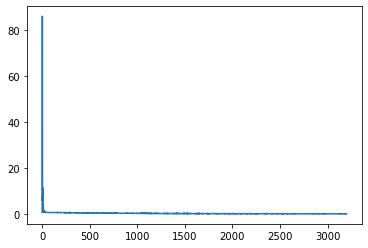

In [125]:
plt.plot(epoch_hist, loss_hist)

In [126]:
model_test = torch.load('/home/past/payal/SSL-based-Automatic-Stutter-Detection-/500_epoch_100_min_2.pth')
model_test.eval()

StutterNet(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer1_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=113664, out_features=4000, bias=True)
  (fc2): Linear(in_features=4000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
  (fc5): Linear(in_f

In [128]:
# test_loader = DataLoader(dataset=test_dataset,
#                           batch_size=batch_size,
#                           shuffle=True,
#                           num_workers=1)
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
   n_correct = 0
   # Compute F1 score, precision and recall
   predicted_stutter = 0
   labels_stutter = 0
   correct_stutter = 0
   i = 0
   final_label = []
   final_predicted = []
   for features, labels in test_loader:
      #  print(labels)
      #  print(np.shape(features))
       features = features.to(device)
      #  print(labels)
       labels = labels.to(device)
       outputs = model_test(features)
    #    print(np.shape(outputs))
       # max returns (value ,index)
       _, predicted = torch.max(outputs.data, 1)
      #  print(predicted)
    #    print(np.shape(predicted))
      #  label = torch.transpose(labels, -1, 0)
       predicted = torch.reshape(predicted,(outputs.shape[0],1))
      #  print('====================================')
      #  print(predicted)
      #  i = i+1
    #    print(n_correct)
      #  final_label.append(label)
      #  final_predicted.append(predicted)
      #  for i in range (0, outputs.shape[0]) :
      #          # F1 score for stutter
      #       if (predicted[i] == 1) :
      #           predicted_stutter +=1
      #       if (labels[i] == 1) :
      #           labels_stutter +=1   
      #       if ((predicted[i] == 1) & (labels[i] == 1)):
      #           correct_stutter +=1
      #       if (predicted[i] == labels[i]) :
      #           n_correct = n_correct + 1

for i in range (0, len(predicted)) :
    # F1 score for stutter
    if (predicted[i] == 1) :
        predicted_stutter +=1
    if (labels[i] == 1) :
        labels_stutter +=1   
    if ((predicted[i] == 1) & (labels[i] == 1)):
        correct_stutter +=1
    if (predicted[i] == labels[i]) :
                n_correct = n_correct + 1

acc_test = 100*n_correct/n_samples_test
print(f'Accuracy of the network on test dataset is : {acc_test} %')
recall = correct_stutter/ labels_stutter
precision = correct_stutter / predicted_stutter
f1_score = 2 * precision * recall / (precision + recall)    
print(f'Precision of the network on test dataset is : {precision}')
print(f'Recall of the network on test dataset is : {recall}')
print(f'F1 Score of the network on test dataset is : {f1_score}')
writer.close()

Accuracy of the network on test dataset is : 58.58585858585859 %
Precision of the network on test dataset is : 0.5977011494252874
Recall of the network on test dataset is : 0.5252525252525253
F1 Score of the network on test dataset is : 0.5591397849462367
